<a href="https://colab.research.google.com/github/KiykoHanna/Stepik-DeepLearning/blob/main/Hanna_Kiyko_600727206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [2]:
!pip install -U torch torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# установка подходящей версии torch
!pip3 install wheel==0.34.1
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torchvision
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
!pip uninstall -y Pillow
!pip install pillow==7.1.2
import PIL


Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-7.1.2-cp39-cp39-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.25.1 requires pillow>=8.3.2, but you have pillow 7.1.2 which is incompatible.


### Подключимся к Кагглу и скачаем файлы. Заодно подключим гугл драйв

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download journey-springfield

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 520M/521M [00:24<00:00, 23.8MB/s]
100% 521M/521M [00:24<00:00, 22.1MB/s]


In [6]:
!unzip /content/journey-springfield.zip


Archive:  /content/journey-springfield.zip
replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!ls train

simpsons_dataset


In [8]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Apr 13 08:49:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# Сначала реализуем предложенную самую простую сеть

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

!pip install matplotlib
import matplotlib as plt
from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

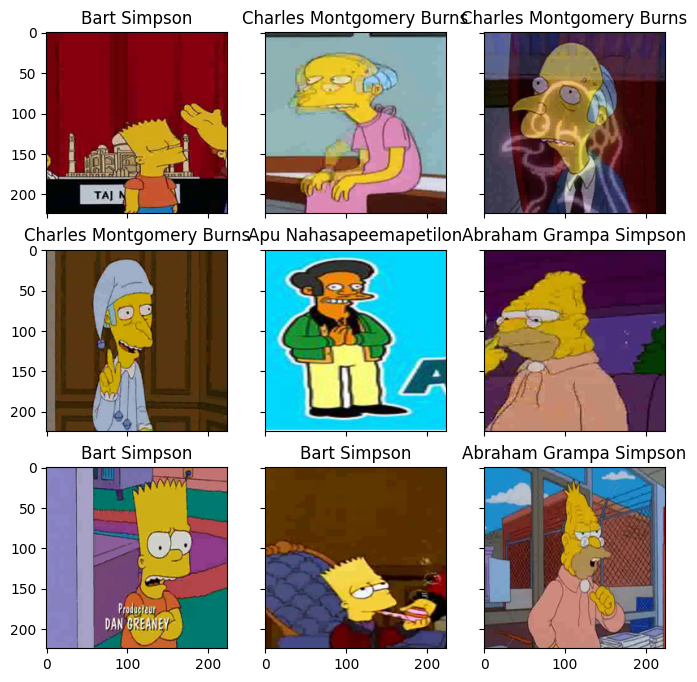

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [97]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [98]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [99]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [100]:
def train(train_files, val_files, model, epochs, batch_size, lrate):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = lrate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [101]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [26]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=8, batch_size=64, lrate=0.0001)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 3.0251304241599333


epoch:  12%|█▎        | 1/8 [02:20<16:19, 140.00s/it]


Epoch 001 train_loss: 3.0251     val_loss 2.6335 train_acc 0.1639 val_acc 0.2853
loss 2.4462799573067655


epoch:  25%|██▌       | 2/8 [04:33<13:38, 136.40s/it]


Epoch 002 train_loss: 2.4463     val_loss 2.3300 train_acc 0.3256 val_acc 0.3726
loss 2.1799933892373438


epoch:  38%|███▊      | 3/8 [06:46<11:13, 134.73s/it]


Epoch 003 train_loss: 2.1800     val_loss 2.1066 train_acc 0.4045 val_acc 0.4410
loss 1.9555410451437685


epoch:  50%|█████     | 4/8 [08:58<08:55, 133.79s/it]


Epoch 004 train_loss: 1.9555     val_loss 1.9198 train_acc 0.4677 val_acc 0.4943
loss 1.7347888655021346


epoch:  62%|██████▎   | 5/8 [11:10<06:38, 132.86s/it]


Epoch 005 train_loss: 1.7348     val_loss 1.7564 train_acc 0.5334 val_acc 0.5378
loss 1.5510967939368812


epoch:  75%|███████▌  | 6/8 [13:23<04:25, 132.93s/it]


Epoch 006 train_loss: 1.5511     val_loss 1.6424 train_acc 0.5786 val_acc 0.5634
loss 1.4073387071565273


epoch:  88%|████████▊ | 7/8 [15:34<02:12, 132.39s/it]


Epoch 007 train_loss: 1.4073     val_loss 1.5400 train_acc 0.6153 val_acc 0.5927
loss 1.2773225148685936


epoch: 100%|██████████| 8/8 [17:46<00:00, 133.34s/it]


Epoch 008 train_loss: 1.2773     val_loss 1.4597 train_acc 0.6530 val_acc 0.6137


Построим кривые обучения

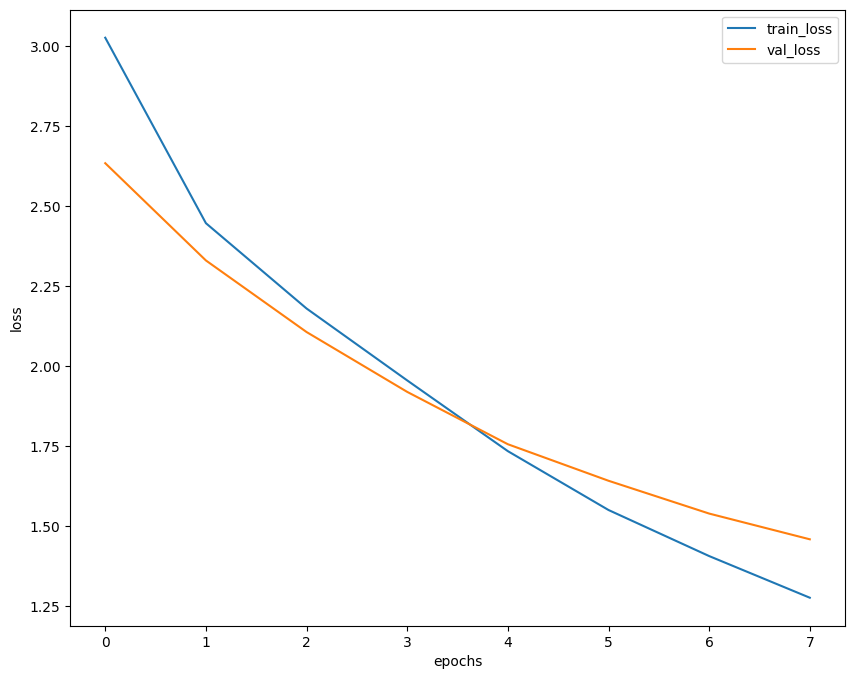

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [27]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [28]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
print(ex_img, true_label)
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))


tensor([[[-1.0219, -1.0219, -1.0219,  ..., -1.7754, -1.7754, -1.7754],
         [ 1.1872,  1.1872,  1.1700,  ..., -0.0801, -0.0458, -0.0458],
         [ 1.3413,  1.3413,  1.3242,  ...,  0.2624,  0.2796,  0.2796],
         ...,
         [-0.3712,  0.4166, -0.6452,  ...,  0.3994,  0.3994,  0.4166],
         [ 0.7077, -0.5938, -0.5596,  ...,  0.1768,  0.1939,  0.2111],
         [-1.2788, -1.8782, -1.5185,  ..., -0.9363, -0.8849, -0.8678]],

        [[-1.2654, -1.2654, -1.2479,  ..., -1.4930, -1.4755, -1.4755],
         [ 0.9755,  0.9930,  0.9755,  ...,  0.4853,  0.5028,  0.5028],
         [ 1.0980,  1.0980,  1.0805,  ...,  0.7654,  0.7829,  0.7829],
         ...,
         [-0.3025,  0.3978, -0.8803,  ..., -0.5826, -0.5826, -0.5826],
         [ 1.0280, -0.4601, -0.7052,  ..., -0.6352, -0.6352, -0.6352],
         [-0.9153, -1.6856, -1.6331,  ..., -1.7206, -1.6856, -1.6856]],

        [[-1.4733, -1.4733, -1.4559,  ..., -0.6018, -0.6018, -0.6018],
         [ 0.3742,  0.3742,  0.3742,  ...,  1

In [29]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)


In [31]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
print(list(y_pred))
actual_labels = [val_dataset[id][1] for id in idxs]
print(actual_labels)
preds_class = [label_encoder.classes_[i] for i in y_pred]


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [33]:
from sklearn.metrics import f1_score
f_metr = []
f_metr.append(f1_score(actual_labels, list(y_pred), average ='micro'))

In [ ]:
f_metr

[0.6]

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

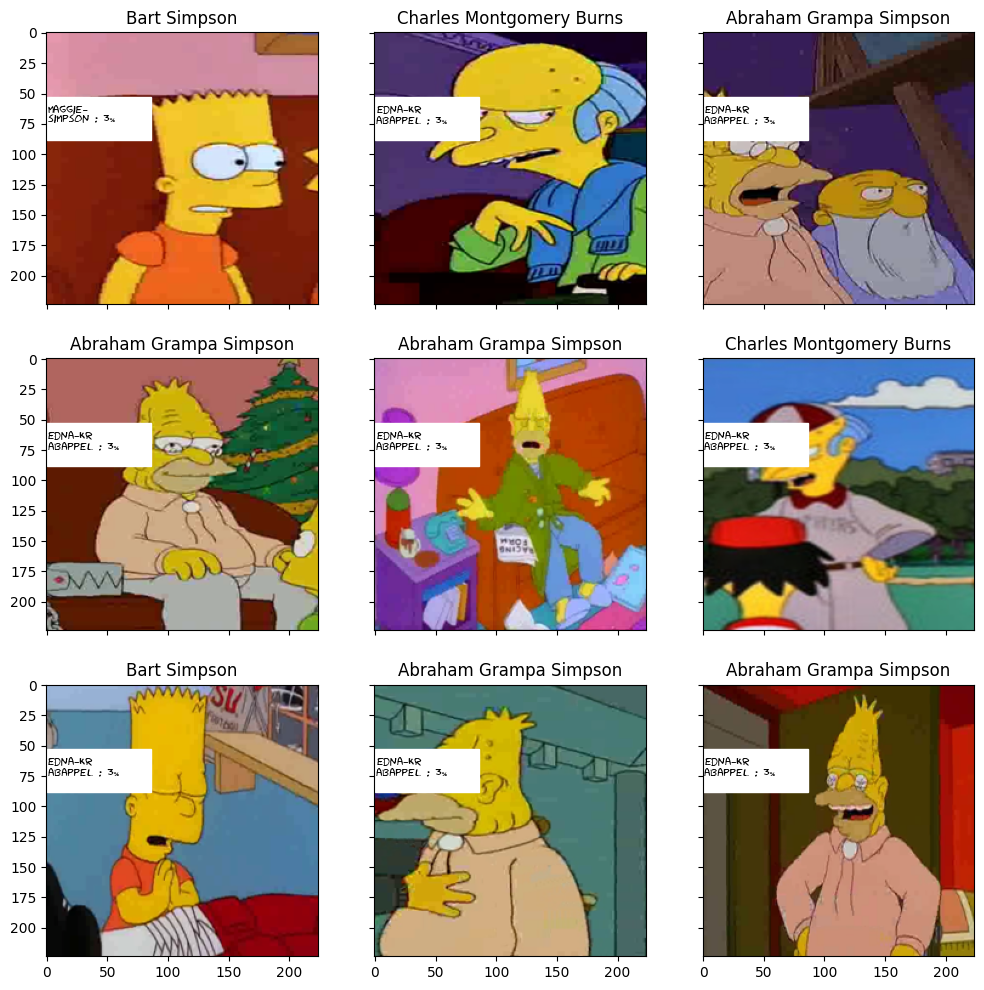

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [35]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [36]:
! ls 

characters_illustration.png  kaggle.json	sample_submission.csv
gdrive			     label_encoder.pkl	testset
journey-springfield.zip      sample_data	train


In [37]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,edna_krabappel
1,img1.jpg,krusty_the_clown
2,img10.jpg,edna_krabappel
3,img100.jpg,apu_nahasapeemapetilon
4,img101.jpg,edna_krabappel


In [ ]:
my_submit.to_csv('/content/testset/simple_cnn_baseline.csv', index=False)

# На каггле набираем только 70%. Приувеличении кличества эпох и уменьшении lr доводим точность до 90%.


# Тестируем возможности AlexNet

### Для начала просто пробуем заменить классификатор и обучить сеть

In [38]:
from torchvision import datasets, models, transforms

import time

In [ ]:
model_al = models.alexnet(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_al.classifier = nn.Linear(num_features, n_classes)

model_al.to(DEVICE)
history = train(train_dataset, val_dataset, model=model_al, epochs=8, batch_size=64, lrate=0.001)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.192088239071012


epoch:  12%|█▎        | 1/8 [02:26<17:08, 146.97s/it]


Epoch 001 train_loss: 2.1921     val_loss 1.2113 train_acc 0.3991 val_acc 0.6771
loss 0.9762038621972933


epoch:  25%|██▌       | 2/8 [04:49<14:27, 144.58s/it]


Epoch 002 train_loss: 0.9762     val_loss 0.7514 train_acc 0.7378 val_acc 0.8040
loss 0.6241855584984335


epoch:  38%|███▊      | 3/8 [07:23<12:24, 148.88s/it]


Epoch 003 train_loss: 0.6242     val_loss 0.7478 train_acc 0.8312 val_acc 0.8149
loss 0.44684137985906647


epoch:  50%|█████     | 4/8 [09:50<09:52, 148.02s/it]


Epoch 004 train_loss: 0.4468     val_loss 0.6854 train_acc 0.8735 val_acc 0.8372
loss 0.3578870018862396


epoch:  62%|██████▎   | 5/8 [12:20<07:26, 148.73s/it]


Epoch 005 train_loss: 0.3579     val_loss 0.7308 train_acc 0.8971 val_acc 0.8403
loss 0.3129586756307233


epoch:  75%|███████▌  | 6/8 [14:41<04:52, 146.22s/it]


Epoch 006 train_loss: 0.3130     val_loss 0.6599 train_acc 0.9113 val_acc 0.8582
loss 0.2589864001333945


epoch:  88%|████████▊ | 7/8 [16:55<02:22, 142.23s/it]


Epoch 007 train_loss: 0.2590     val_loss 0.7909 train_acc 0.9254 val_acc 0.8248
loss 0.2943191899582188


epoch: 100%|██████████| 8/8 [19:10<00:00, 143.86s/it]


Epoch 008 train_loss: 0.2943     val_loss 0.7961 train_acc 0.9174 val_acc 0.8408


In [ ]:
probs_ims = predict(model_al, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f_metr.append(f1_score(actual_labels, list(y_pred), average ='micro'))
f_metr[-1]

0.85

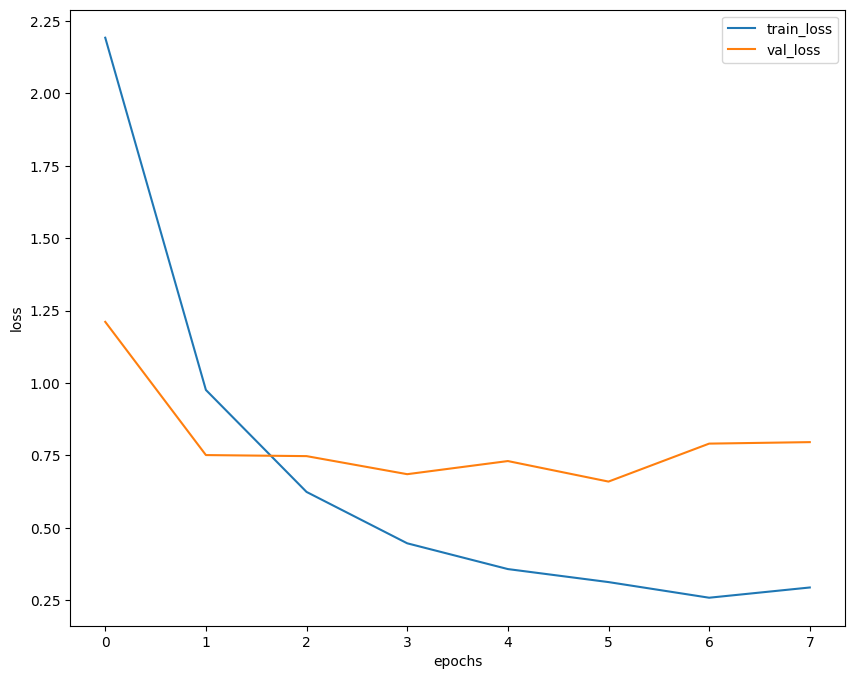

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [ ]:
probs_al = predict(model_al, test_loader)

preds_al = label_encoder.inverse_transform(np.argmax(probs_al, axis=1))
test_filenames_al = [path.name for path in test_dataset.files]
my_submit_al = pd.DataFrame({'Id': test_filenames_al, 'Expected': preds_al})

my_submit_al.to_csv('/content/testset/simple_cnn_baseline_al.csv', index=False)

### Как видно, эта модель дает гораздо более точные результаты.

# Теперь попробуем AlexNet с заморозкой слоев

Переопределим функцию обучения для использования заморозки слоев

In [25]:
def train_mod(train_files, val_files, model, epochs, batch_size, optimaser):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimaser
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

### Зададим модель и установим колличество замороженных слоев: 6.

In [ ]:
model_mixed = models.alexnet(pretrained=True)

layers_to_unfreeze = 6

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, n_classes)

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
optimizer = torch.optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.0001)

model_mixed.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [ ]:
history = train_mod(train_dataset, val_dataset, model=model_mixed, epochs=8, batch_size=64, optimaser=optimizer)


epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.3443602563028951


epoch:  12%|█▎        | 1/8 [02:02<14:16, 122.42s/it]


Epoch 001 train_loss: 1.3444     val_loss 0.6787 train_acc 0.6516 val_acc 0.8217
loss 0.2730432382250099


epoch:  25%|██▌       | 2/8 [04:02<12:04, 120.83s/it]


Epoch 002 train_loss: 0.2730     val_loss 0.5119 train_acc 0.9307 val_acc 0.8665
loss 0.06969307573561198


epoch:  38%|███▊      | 3/8 [06:03<10:05, 121.10s/it]


Epoch 003 train_loss: 0.0697     val_loss 0.4926 train_acc 0.9879 val_acc 0.8817
loss 0.018743426769476376


epoch:  50%|█████     | 4/8 [08:04<08:04, 121.08s/it]


Epoch 004 train_loss: 0.0187     val_loss 0.5118 train_acc 0.9992 val_acc 0.8854
loss 0.009508352970933545


epoch:  62%|██████▎   | 5/8 [10:05<06:02, 120.93s/it]


Epoch 005 train_loss: 0.0095     val_loss 0.5276 train_acc 0.9997 val_acc 0.8840
loss 0.0038923191465502667


epoch:  75%|███████▌  | 6/8 [12:08<04:03, 121.60s/it]


Epoch 006 train_loss: 0.0039     val_loss 0.5673 train_acc 0.9999 val_acc 0.8829
loss 0.005358060928347189


epoch:  88%|████████▊ | 7/8 [14:16<02:03, 123.78s/it]


Epoch 007 train_loss: 0.0054     val_loss 0.5291 train_acc 0.9997 val_acc 0.8884
loss 0.004595794705458411


epoch: 100%|██████████| 8/8 [16:21<00:00, 122.67s/it]


Epoch 008 train_loss: 0.0046     val_loss 0.5420 train_acc 0.9998 val_acc 0.8878


In [ ]:
probs_ims = predict(model_mixed, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f_metr.append(f1_score(actual_labels, list(y_pred), average ='micro'))
f_metr[-1]

0.9500000000000001

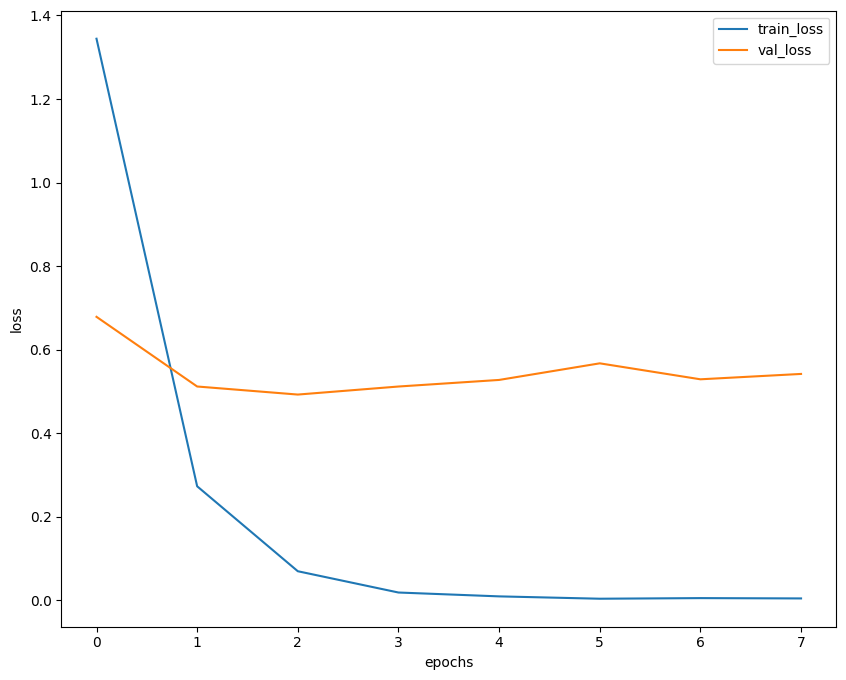

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
probs_al_mix = predict(model_mixed, test_loader)

preds_al_mix = label_encoder.inverse_transform(np.argmax(probs_al_mix, axis=1))
test_filenames_al = [path.name for path in test_dataset.files]
my_submit_mixed = pd.DataFrame({'Id': test_filenames_al, 'Expected': preds_al_mix})

my_submit_mixed.to_csv('/content/testset/simple_cnn_baseline_mixed.csv', index=False)

# Результаты этой модели еще лучше. На каггле получаем 96%. Но этого еще недостаточно.

---



# Протестируем модель VGG16

In [45]:
from torch.optim import lr_scheduler

In [46]:
def fit_epoch_sh(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()    

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def train_mod(train_files, val_files, model, epochs, batch_size, optimaser, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimaser
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch_sh(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [47]:
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, n_classes)

# Обучаем только классификатор
optimizer = torch.optim.SGD(model_extractor.classifier.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_extractor.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
history = train_mod(train_dataset, val_dataset, model=model_extractor, epochs=8, batch_size=64, optimaser=optimizer, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.412125729073293


epoch:  12%|█▎        | 1/8 [03:43<26:03, 223.31s/it]


Epoch 001 train_loss: 2.4121     val_loss 1.8421 train_acc 0.4003 val_acc 0.5820
loss 1.5116284366238382


epoch:  25%|██▌       | 2/8 [07:34<22:47, 227.95s/it]


Epoch 002 train_loss: 1.5116     val_loss 1.4878 train_acc 0.6674 val_acc 0.6578
loss 1.1813778766621996


epoch:  38%|███▊      | 3/8 [11:47<19:57, 239.41s/it]


Epoch 003 train_loss: 1.1814     val_loss 1.3145 train_acc 0.7443 val_acc 0.6888
loss 0.9808150286150249


epoch:  50%|█████     | 4/8 [15:47<15:59, 239.79s/it]


Epoch 004 train_loss: 0.9808     val_loss 1.2031 train_acc 0.7923 val_acc 0.7104
loss 0.8575473455564483


epoch:  62%|██████▎   | 5/8 [19:32<11:43, 234.48s/it]


Epoch 005 train_loss: 0.8575     val_loss 1.1902 train_acc 0.8245 val_acc 0.7157
loss 0.8437663242159182


epoch:  75%|███████▌  | 6/8 [23:25<07:47, 233.67s/it]


Epoch 006 train_loss: 0.8438     val_loss 1.1817 train_acc 0.8280 val_acc 0.7186
loss 0.8313629371974566


epoch:  88%|████████▊ | 7/8 [27:16<03:53, 233.07s/it]


Epoch 007 train_loss: 0.8314     val_loss 1.1734 train_acc 0.8307 val_acc 0.7197


### Изначально видно, что точность этой модели получается низкая, поэтому даже недообучала ее.

### Поробуем заморозить только 18 слоев.

In [53]:
model_extractor_sh = models.vgg16(pretrained=True)
layers_to_unfreeze = 18

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_extractor_sh.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor_sh.classifier = nn.Linear(num_features, n_classes)    

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
optimizer = torch.optim.Adam(list(model_extractor_sh.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_extractor_sh.classifier.parameters()), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_extractor_sh.to(DEVICE)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
history = train_mod(train_dataset, val_dataset, model=model_extractor_sh, epochs=8, batch_size=64, optimaser=optimizer, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 0.9824101559823012


epoch:  12%|█▎        | 1/8 [04:54<34:23, 294.74s/it]


Epoch 001 train_loss: 0.9824     val_loss 0.3474 train_acc 0.7499 val_acc 0.9129
loss 0.12644199076148915


epoch:  25%|██▌       | 2/8 [09:52<29:40, 296.76s/it]


Epoch 002 train_loss: 0.1264     val_loss 0.3458 train_acc 0.9692 val_acc 0.9165
loss 0.025159746414750835


epoch:  38%|███▊      | 3/8 [15:10<25:31, 306.35s/it]


Epoch 003 train_loss: 0.0252     val_loss 0.3272 train_acc 0.9931 val_acc 0.9280
loss 0.03058809200062692


epoch:  50%|█████     | 4/8 [19:57<19:55, 298.75s/it]


Epoch 004 train_loss: 0.0306     val_loss 0.3891 train_acc 0.9920 val_acc 0.9146
loss 0.005890609490624595


epoch:  62%|██████▎   | 5/8 [24:38<14:36, 292.29s/it]


Epoch 005 train_loss: 0.0059     val_loss 0.3145 train_acc 0.9988 val_acc 0.9373
loss 0.0013013942807076392


epoch:  75%|███████▌  | 6/8 [29:32<09:45, 292.81s/it]


Epoch 006 train_loss: 0.0013     val_loss 0.3276 train_acc 0.9999 val_acc 0.9383
loss 0.000700554517352761


epoch:  88%|████████▊ | 7/8 [34:11<04:48, 288.18s/it]


Epoch 007 train_loss: 0.0007     val_loss 0.3386 train_acc 0.9999 val_acc 0.9385
loss 0.0004407825578818051


epoch: 100%|██████████| 8/8 [38:47<00:00, 290.99s/it]


Epoch 008 train_loss: 0.0004     val_loss 0.3503 train_acc 0.9999 val_acc 0.9383


In [55]:
probs_ims = predict(model_extractor_sh, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, list(y_pred), average ='micro')


0.9500000000000001

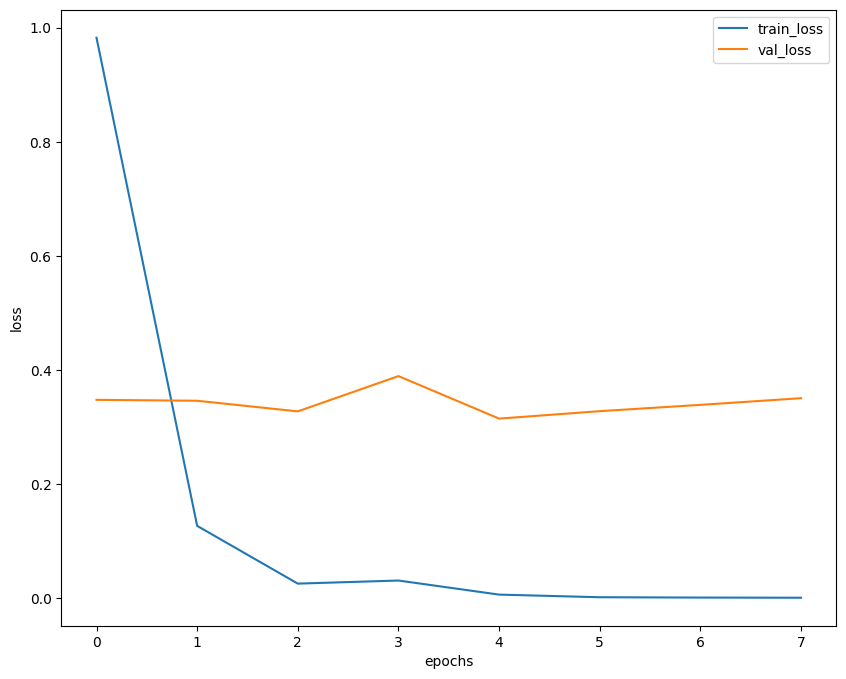

In [56]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(10, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [58]:
import pandas as pd
probs_model_extractor = predict(model_extractor_sh, test_loader)

preds_model_extractor = label_encoder.inverse_transform(np.argmax(probs_model_extractor, axis=1))
test_filenames_al = [path.name for path in test_dataset.files]
my_submit_model_extractor = pd.DataFrame({'Id': test_filenames_al, 'Expected': preds_model_extractor})

my_submit_model_extractor.to_csv('/content/testset/simple_cnn_baseline_model_extractor.csv', index=False)

# Получили очень достойное предсказание на каггле: Score: 0.98724

### Фактически, я получила Score выше 97%, что означает -- задание выполнено. Но я все-таки попробую протестировать еще одну модель.

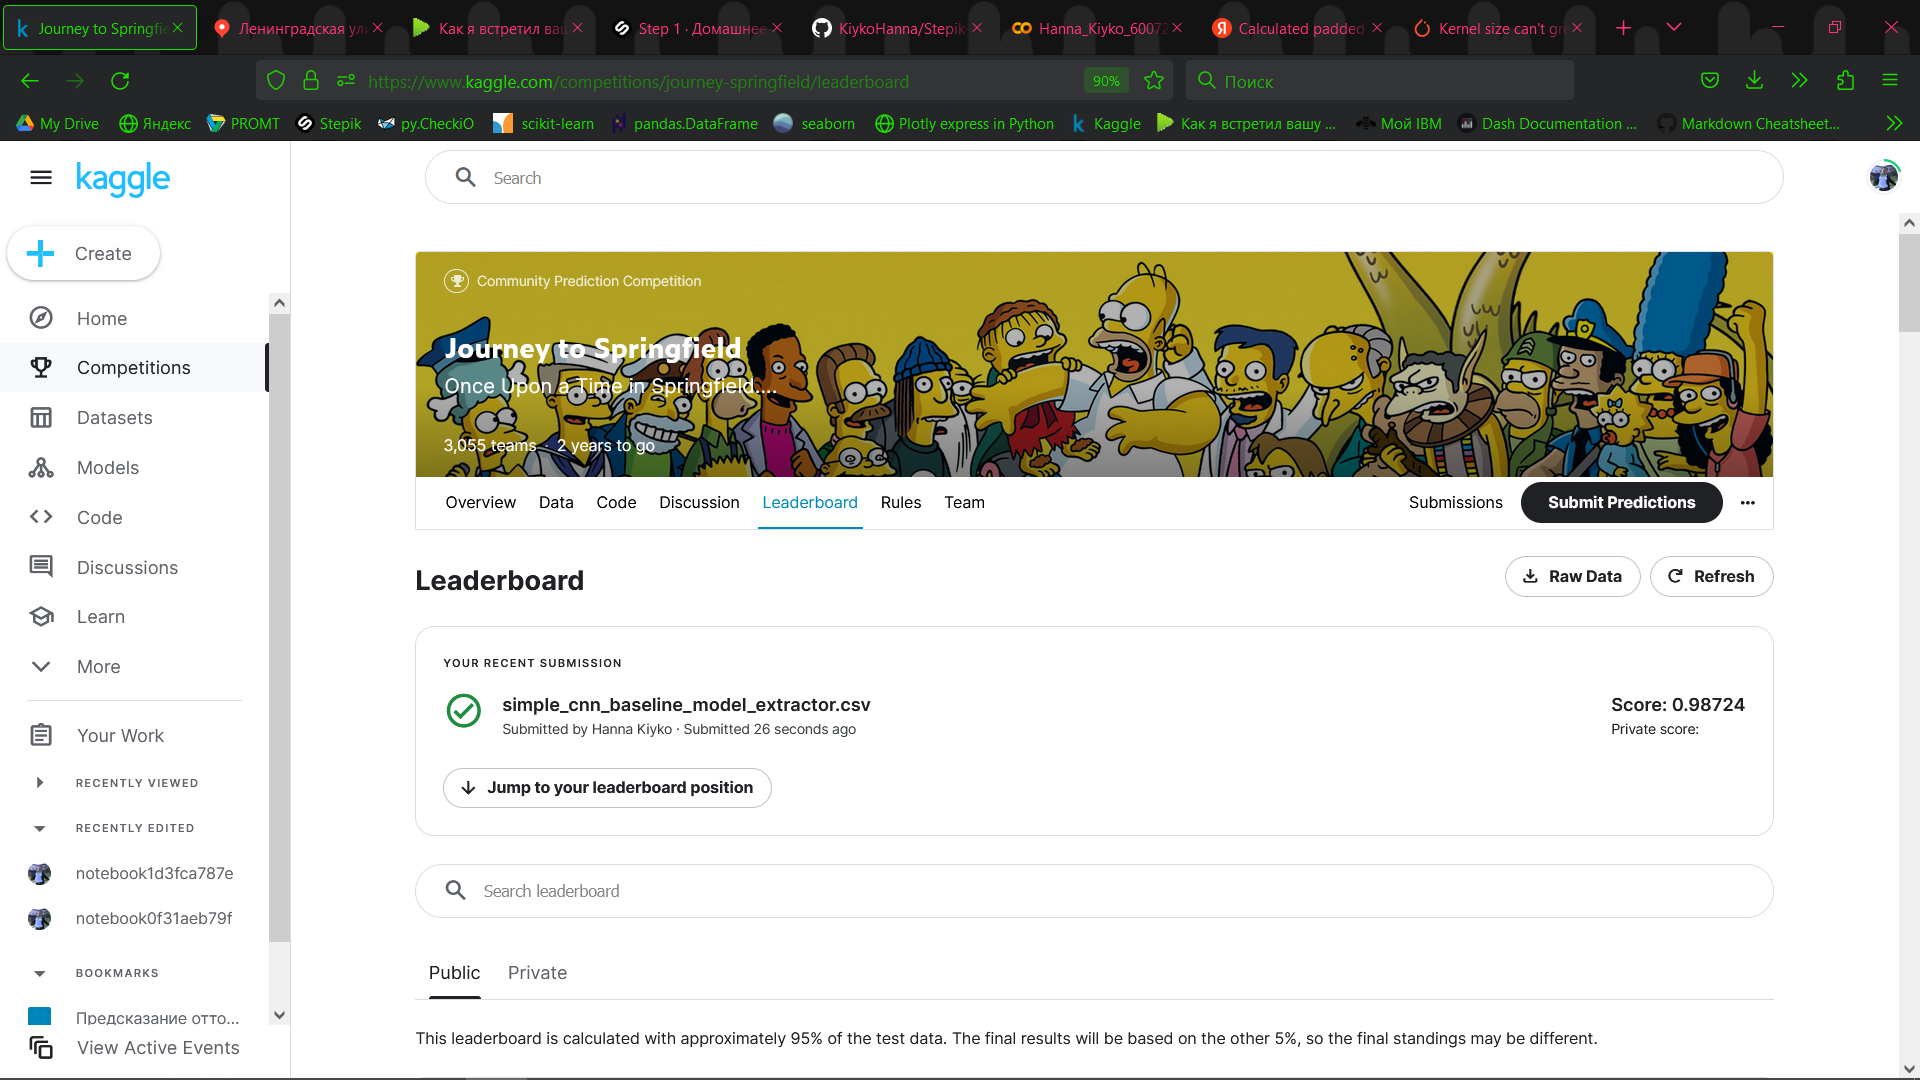

# Протестируем ResNet

### Добавим аугментацию 

In [90]:
class SimpsonsDataset1(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        if self.mode == 'val':
          transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

val_dataset1 = SimpsonsDataset1(val_files, mode='val')
 
train_dataset1 = SimpsonsDataset1(train_files, mode='train')

In [91]:
train_dataset1[0][0].shape

torch.Size([3, 224, 224])

In [96]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, n_classes)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft.to(DEVICE)

RuntimeError: ignored

In [94]:
history = train_mod(train_dataset1, val_dataset1, model=model_ft, epochs=8, batch_size=64, optimaser=optimizer, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
probs_ims = predict(model_inception, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f_metr.append(f1_score(actual_labels, list(y_pred), average ='micro'))
f_metr[-1]

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()